In [1]:
import os
import sys

parent_dir = os.path.dirname('/home/jupyter/')
sys.path.append(parent_dir)

import warnings
warnings.filterwarnings("ignore")

import yaml
import torch
import anndata
import tempfile
import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cudf
import cuml

In [3]:
from cellarium.ml.core import CellariumPipeline, CellariumModule
from cellarium.ml.utilities.data import AnnDataField, densify
from cellarium.ml.core.datamodule import CellariumAnnDataDataModule
from cellarium.ml.data import (
    DistributedAnnDataCollection,
    IterableDistributedAnnDataCollectionDataset,
)

from cellarium.ml.models.nmf import calculate_rec_error, get_embeddding, update_consensusD

In [4]:
class AutosizedDistributedAnnDataCollection(DistributedAnnDataCollection):

    def __init__(self, *args, **kwargs):
        # I'm being lazy here and doing something real ugly
        # I want it to take the shard_size from the first file
        try:
            # this allows super to find the list of filenames
            super().__init__(*args, **kwargs)
        except AssertionError:
            try:
                # this allows super to create the cache
                kwargs.pop("shard_size")
                kwargs = kwargs | {"shard_size": 10000}
                super().__init__(*args, **kwargs)
            except AssertionError:
                pass
            # load first file and cache it
            adata0 = self.cache[self.filenames[0]] = read_h5ad_file(self.filenames[0])
            # pull shard_size from that file
            kwargs.pop("shard_size")
            kwargs = kwargs | {"shard_size": len(adata0)}
            # finally initialize for real
            super().__init__(*args, **kwargs)

def get_pretrained_model_as_pipeline(
    trained_model: str = "../", 
    transforms: list[torch.nn.Module] = [],
    device: str = "cuda",
) -> CellariumPipeline:

    model = CellariumModule.load_from_checkpoint(trained_model).model

    # insert the trained model params
    model.to(device)
    model.eval()

    # construct the pipeline
    pipeline = CellariumPipeline(transforms + [model])

    return pipeline

def get_dataset_from_anndata(
    adata: anndata.AnnData | str, 
    batch_size: int = 2048, 
    shard_size: int | None = None, 
    shuffle: bool = False, 
    seed: int = 0, 
    drop_last: bool = False,
):
    """
    Get IterableDistributedAnnDataCollectionDataset from an AnnData object or h5ad file specifier.

    Args:
        adata: AnnData object or h5ad file, allowing brace notation for several files.
        batch_size: Batch size.
        shard_size: Shard size.
        shuffle: Whether to shuffle the dataset.
        seed: Random seed.
        drop_last: Whether to drop the last incomplete batch.

    Returns:
        IterableDistributedAnnDataCollectionDataset.
    """

    if isinstance(adata, anndata.AnnData):
        tmpfile = tempfile.mkstemp(suffix='.h5ad')
        adata.write(tmpfile[1])
        file = tmpfile[1]
    else:
        file = adata

    dadc = AutosizedDistributedAnnDataCollection(
        file,
        shard_size=shard_size,
        max_cache_size=1,
    )

    dataset = IterableDistributedAnnDataCollectionDataset(
        dadc,
        batch_keys={
            "x_ng": AnnDataField(attr="X", convert_fn=densify),
            "var_names_g": AnnDataField(attr="var_names"),
        },
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        drop_last=drop_last,
    )
    return dataset

In [5]:
config_file = "../yaml/nmf_heart_config_notebook.yaml"
checkpoint_file = '../NMF.ckpt'

In [6]:
# load trained pipeline
pipeline = get_pretrained_model_as_pipeline(
    trained_model=checkpoint_file,
)

In [7]:
# get the location of the dataset
with open(config_file, "r") as file:
    config_dict = yaml.safe_load(file)
data_path = config_dict['data']['dadc']['init_args']['filenames']
print(f'Data is coming from {data_path}')

# get a dataset object
dataset = get_dataset_from_anndata(
    data_path, 
    batch_size=2048,
    shard_size=665234,
    shuffle=False, 
    seed=0, 
    drop_last=False,
)

Data is coming from /home/jupyter/data/human_heart_atlas_hvg_scvi_rec.h5ad


In [10]:
# calculate consensus D for all Ks
density_threshold = 0.2
local_neighborhood_size = 0.3
consensus_stat = update_consensusD(pipeline, 
                                   density_threshold = density_threshold, 
                                   local_neighborhood_size = local_neighborhood_size)

silhouette score of k=10: 0.7344
silhouette score of k=15: 0.7882
silhouette score of k=20: 0.8126
silhouette score of k=25: 0.7898
silhouette score of k=30: 0.6589


k=10


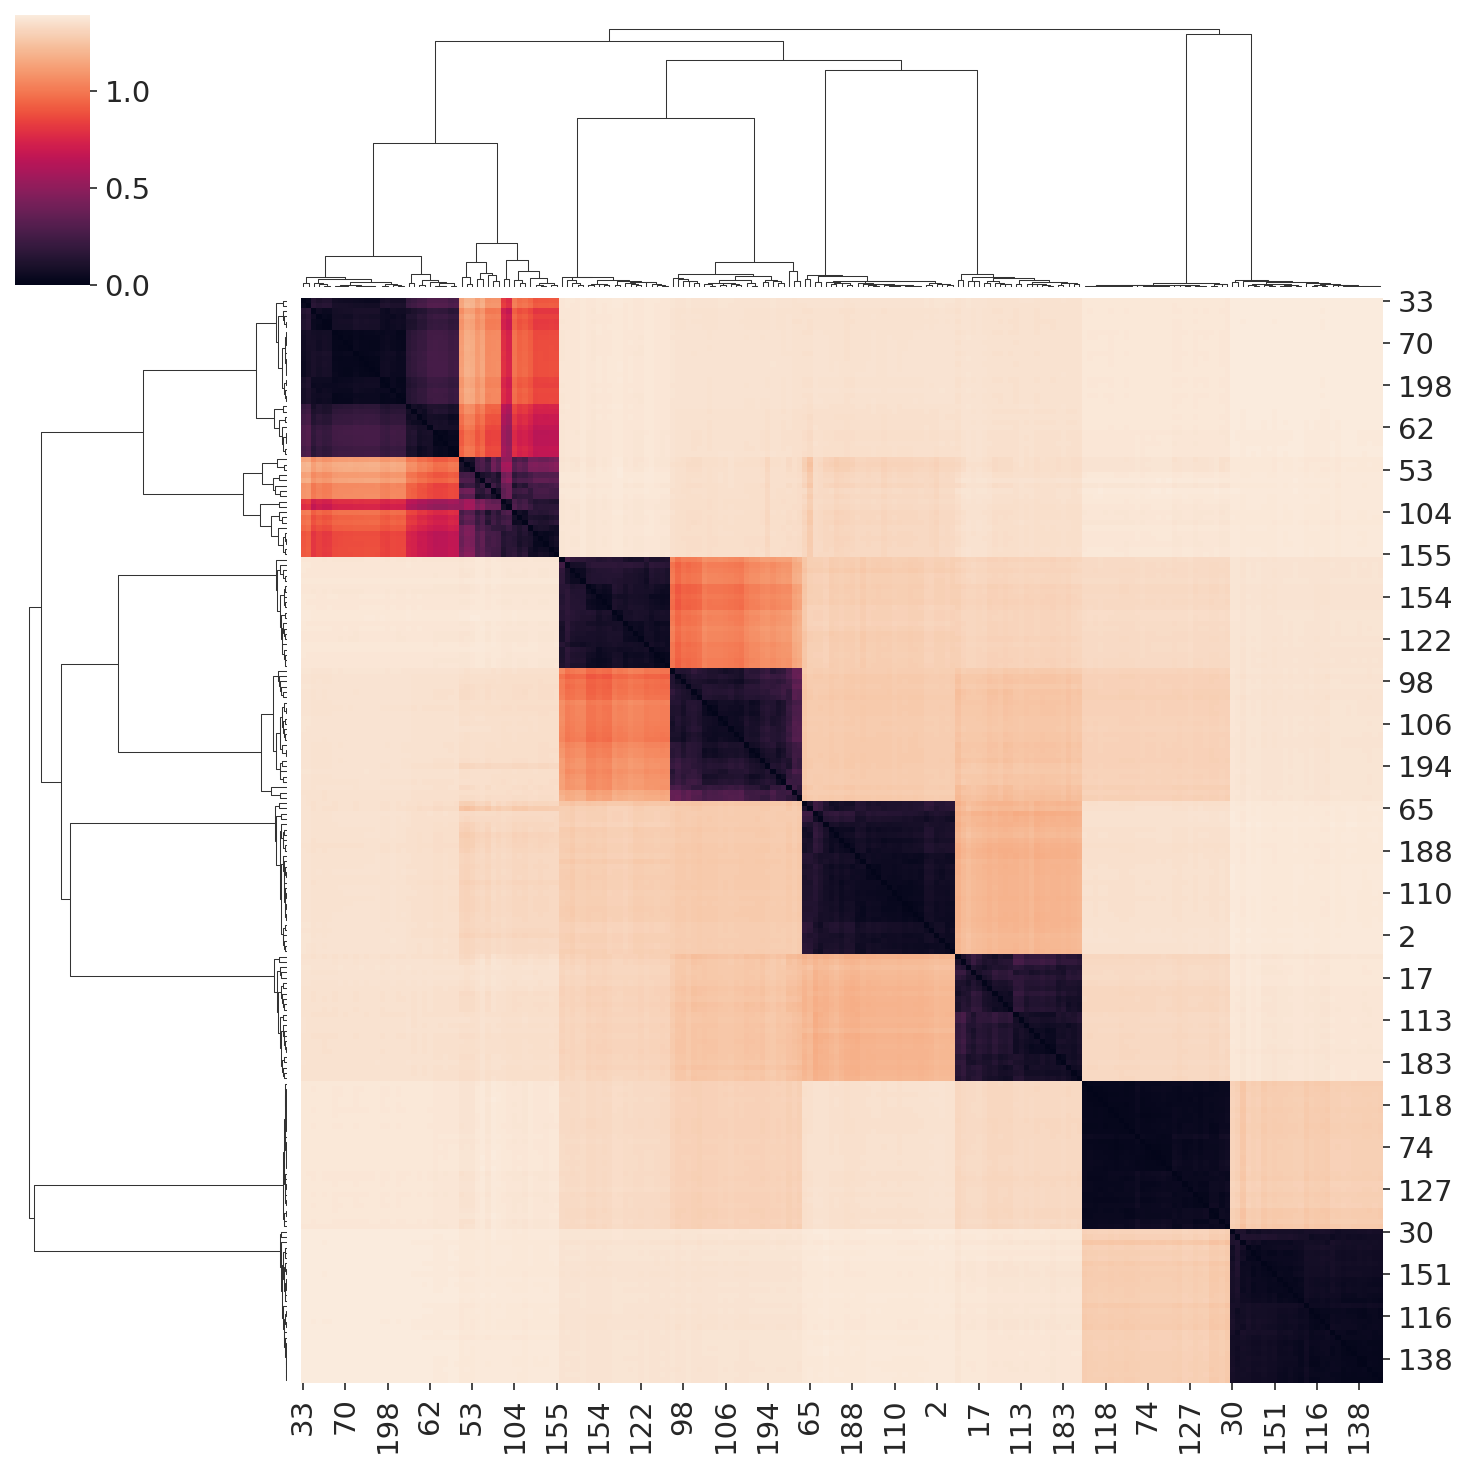

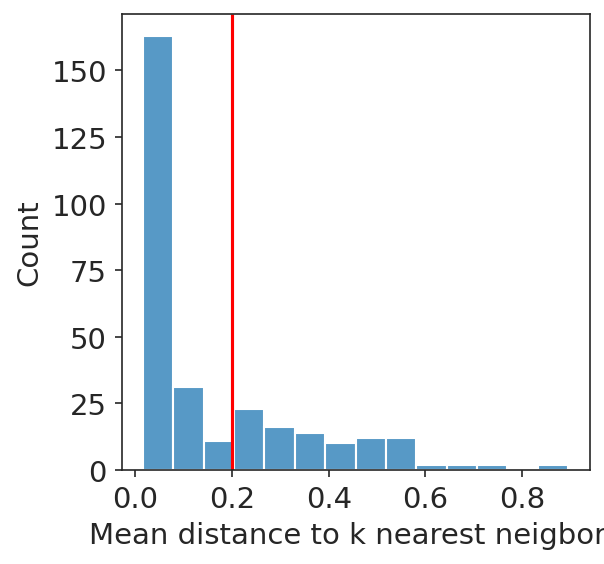

k=15


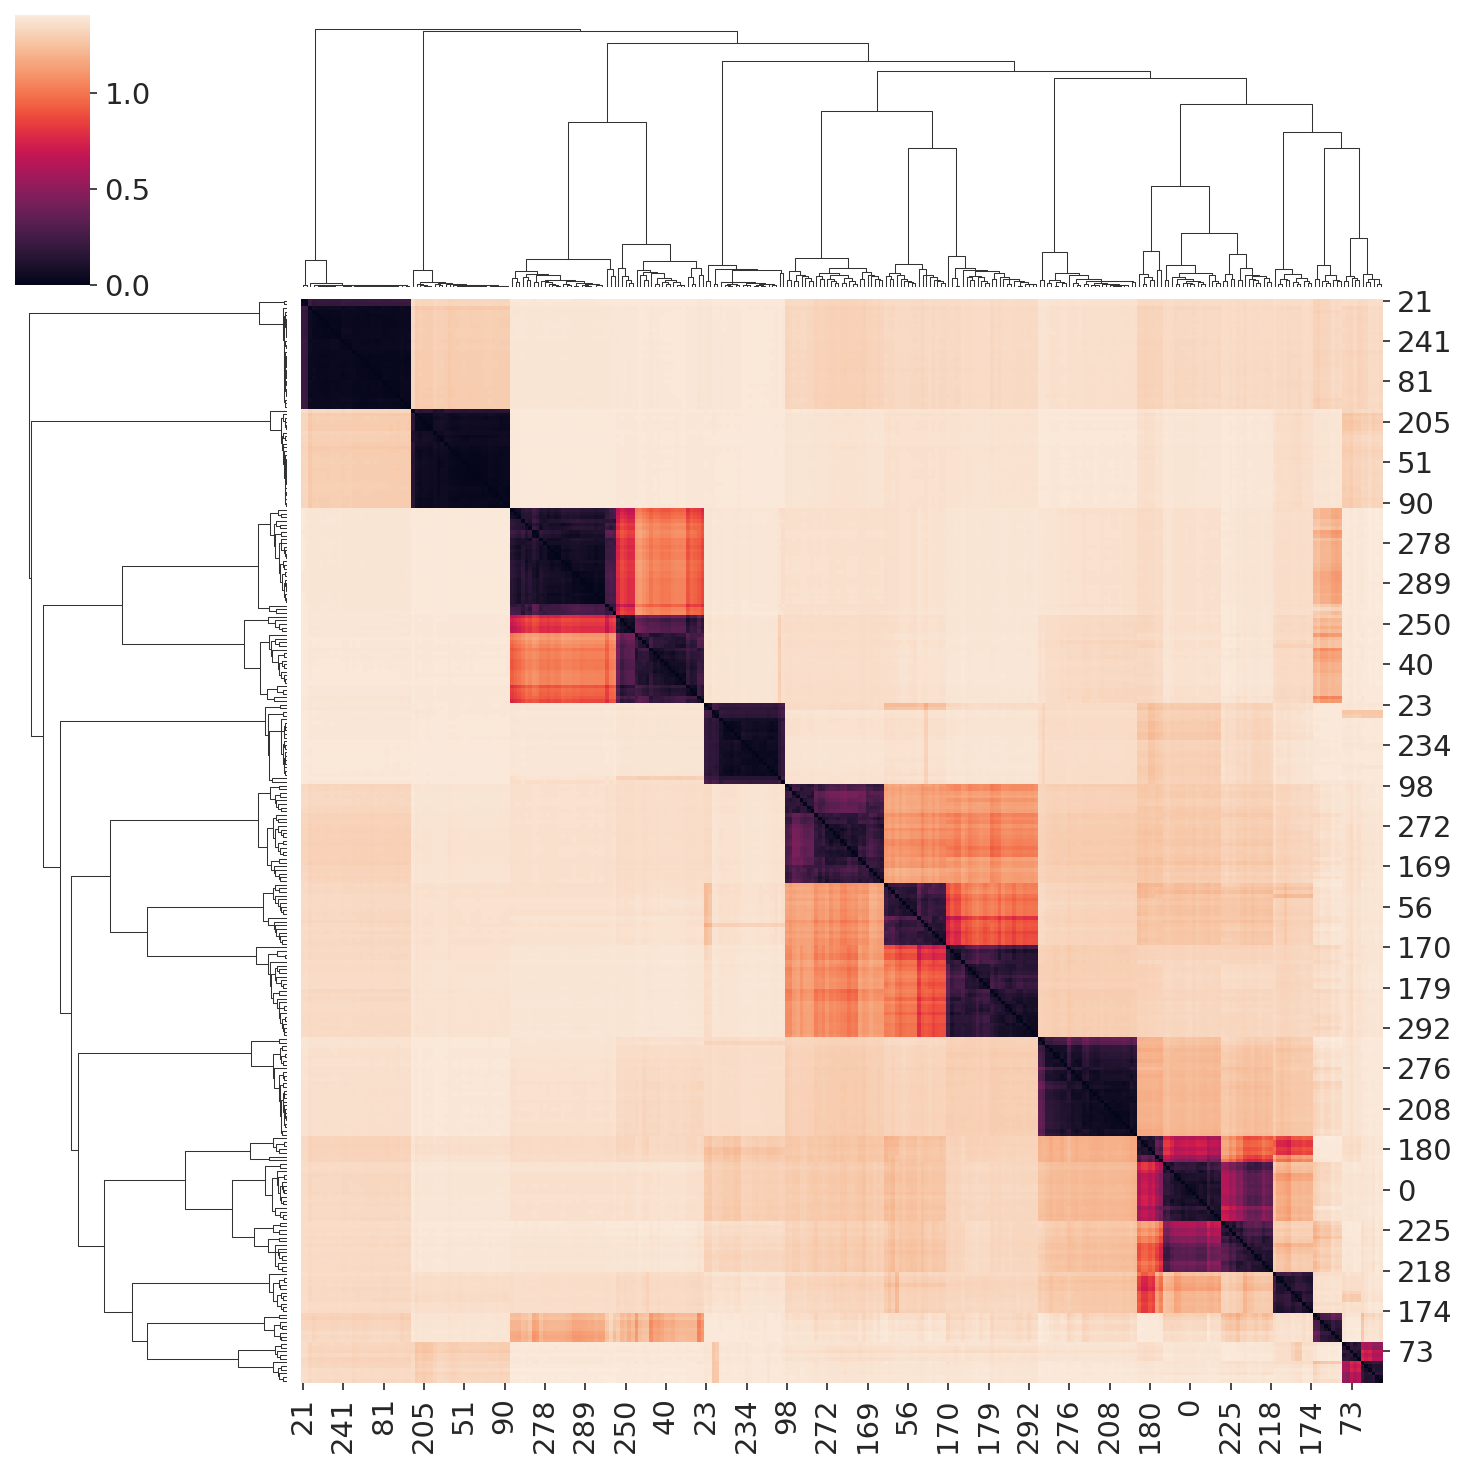

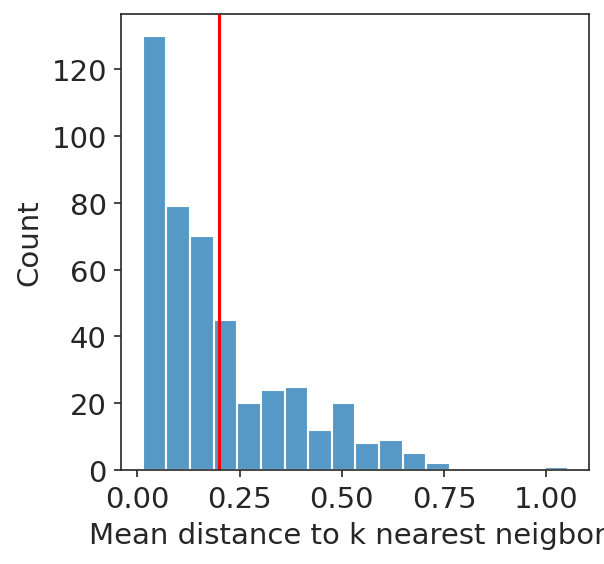

k=20


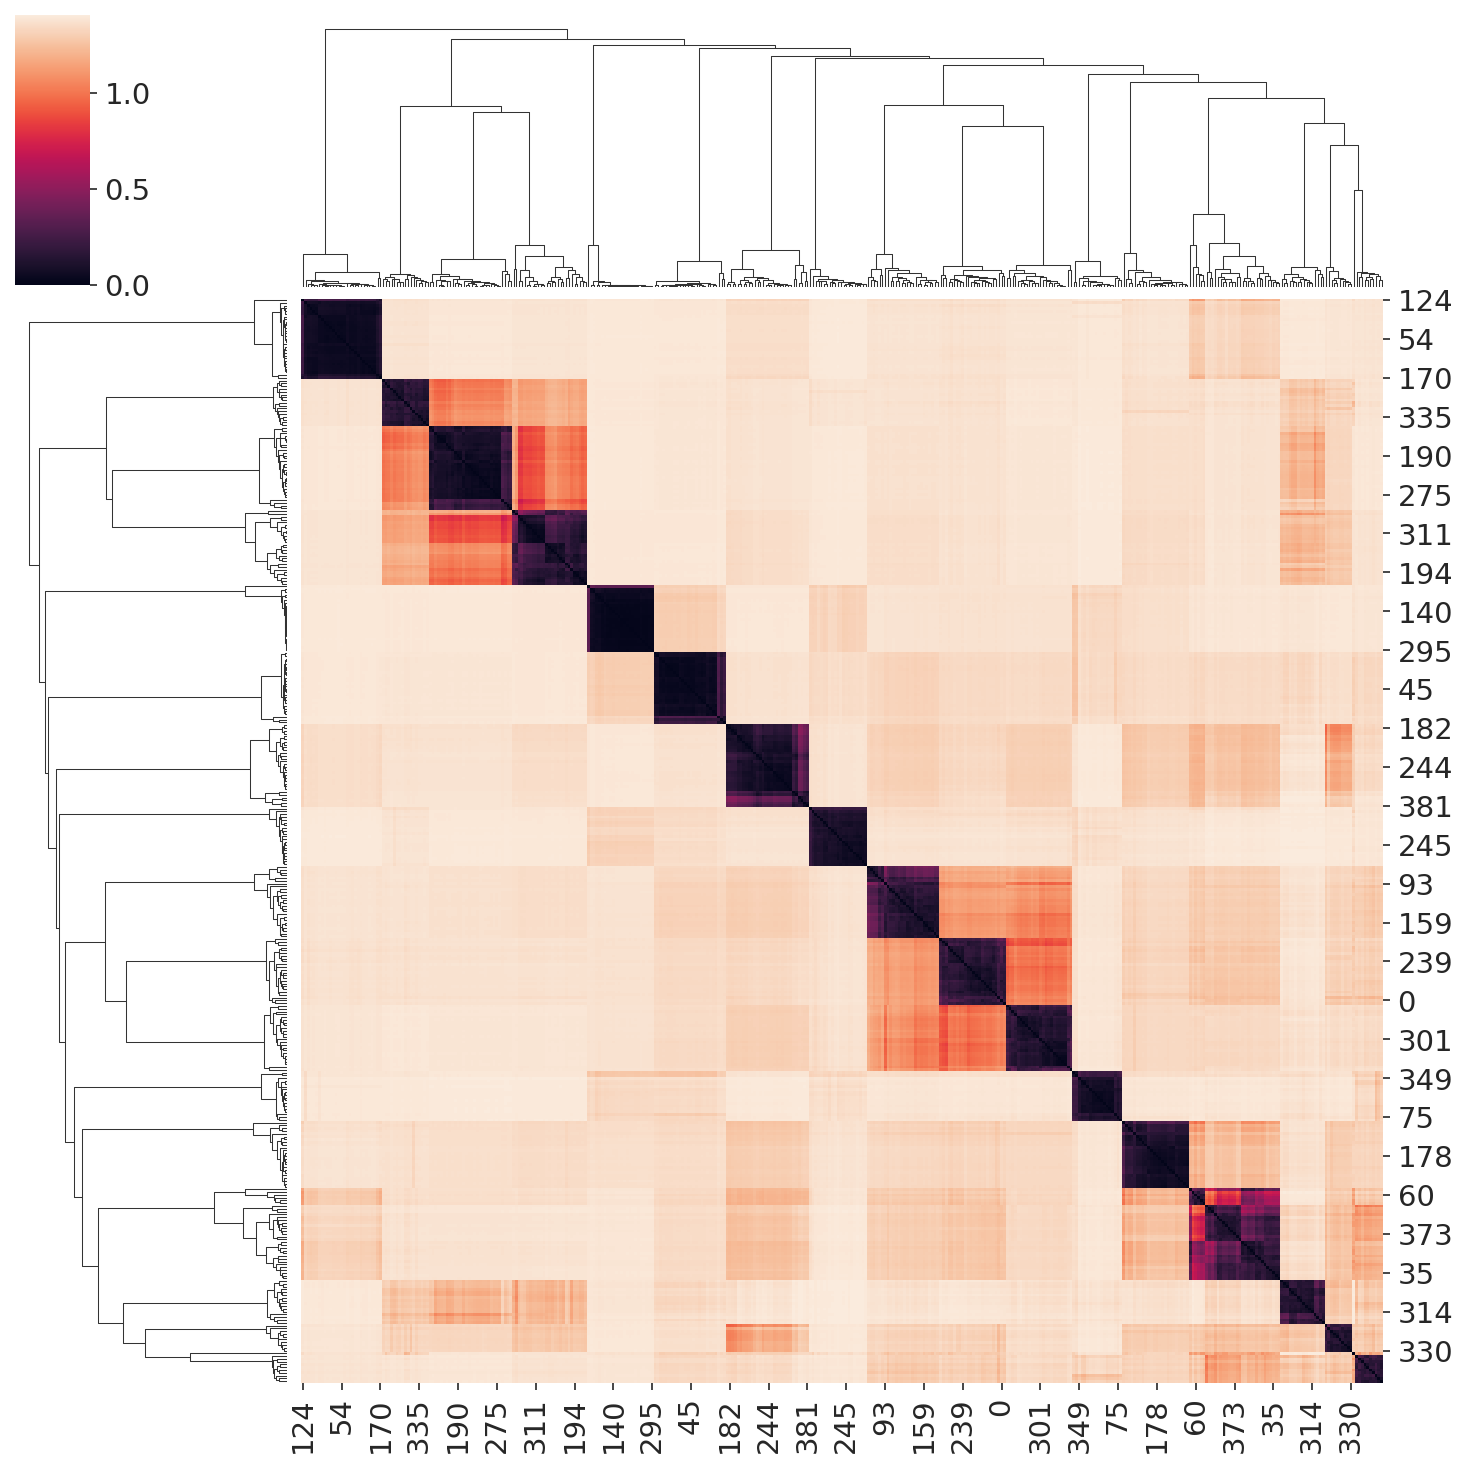

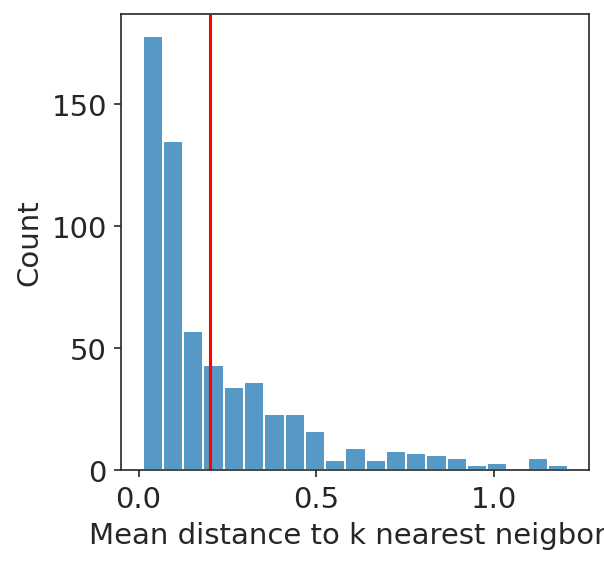

k=25


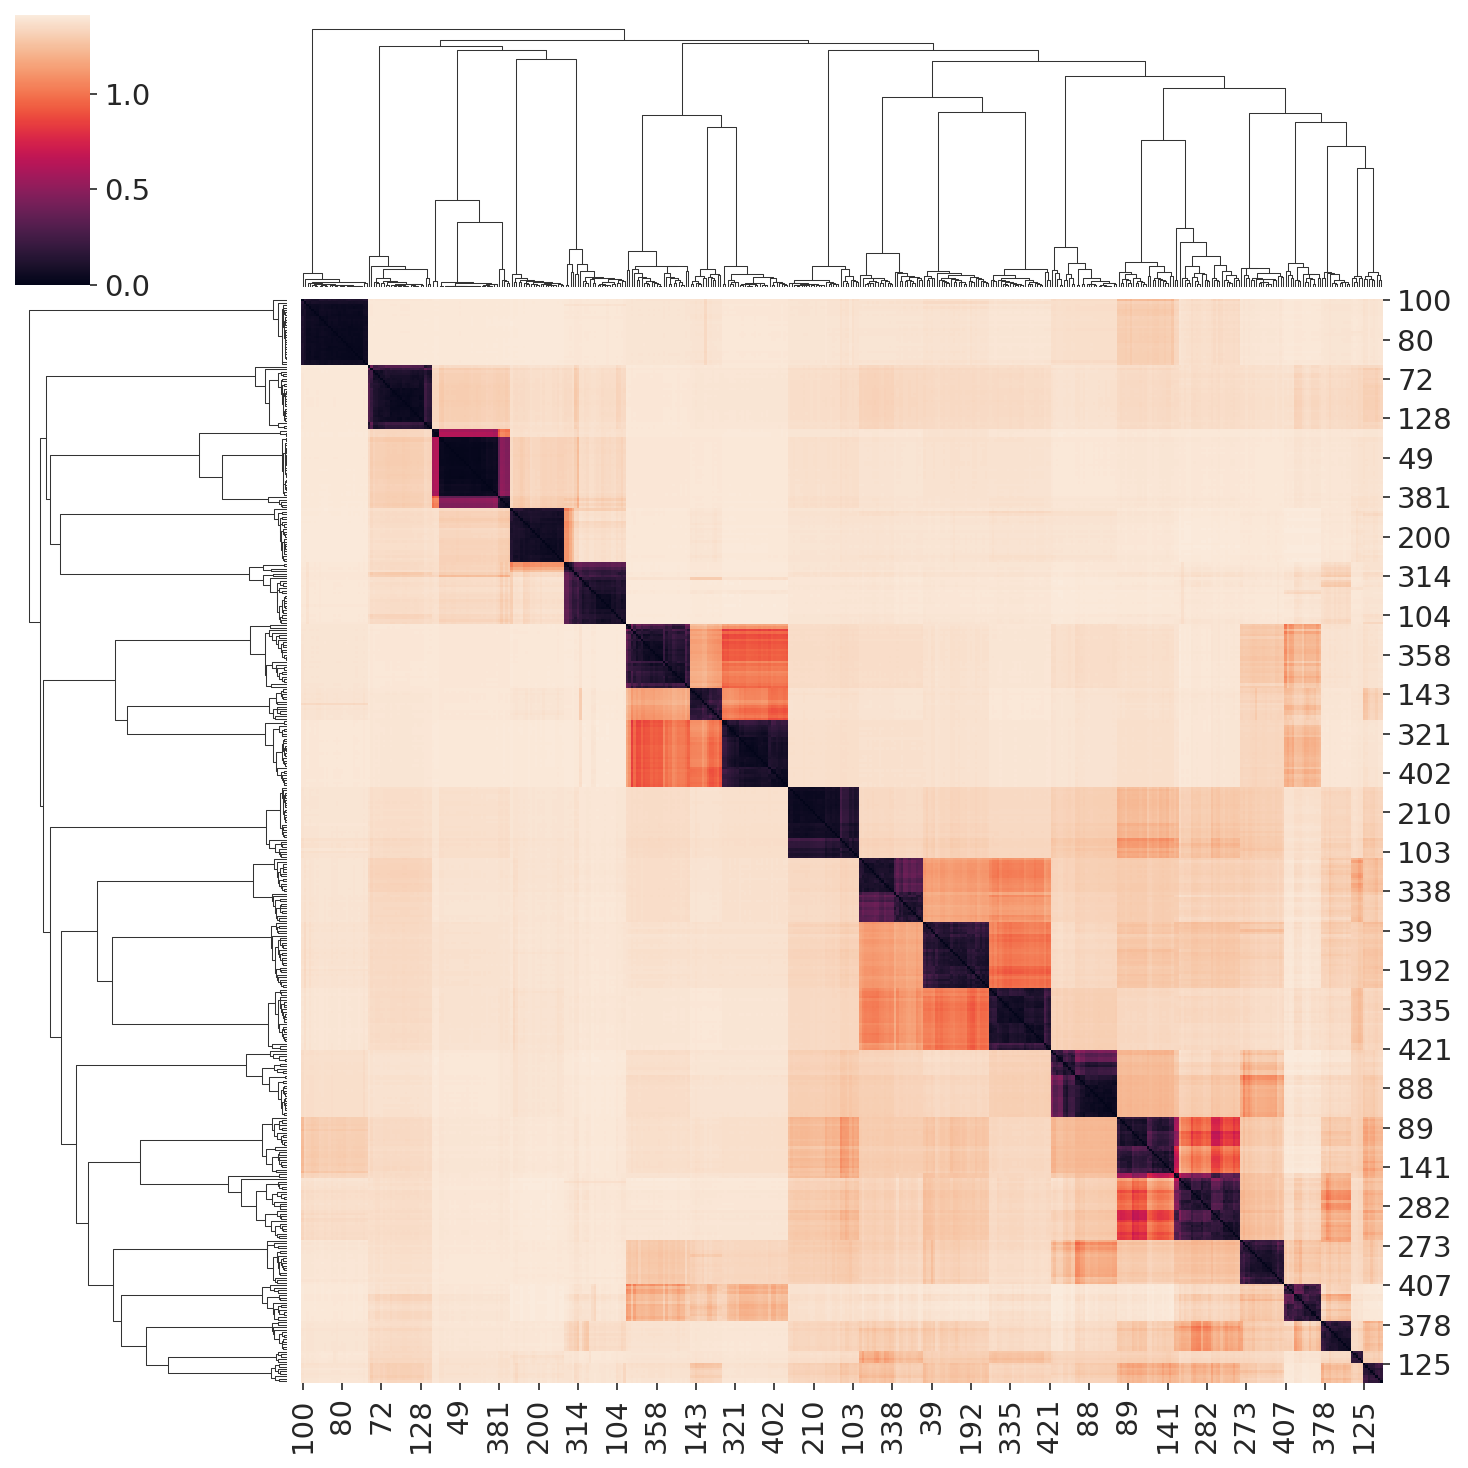

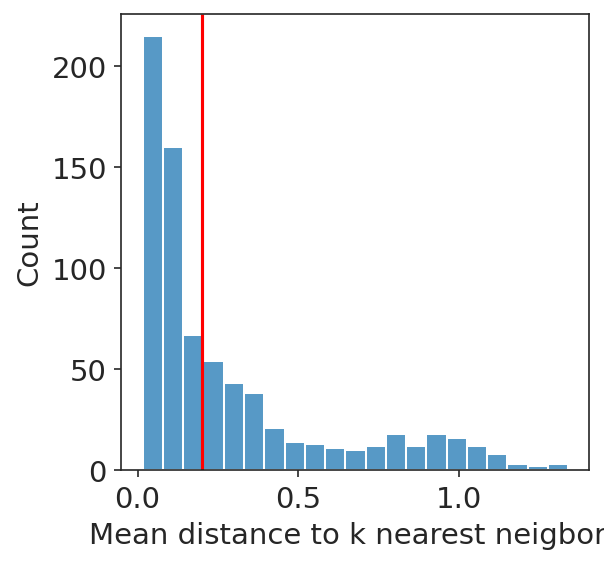

k=30


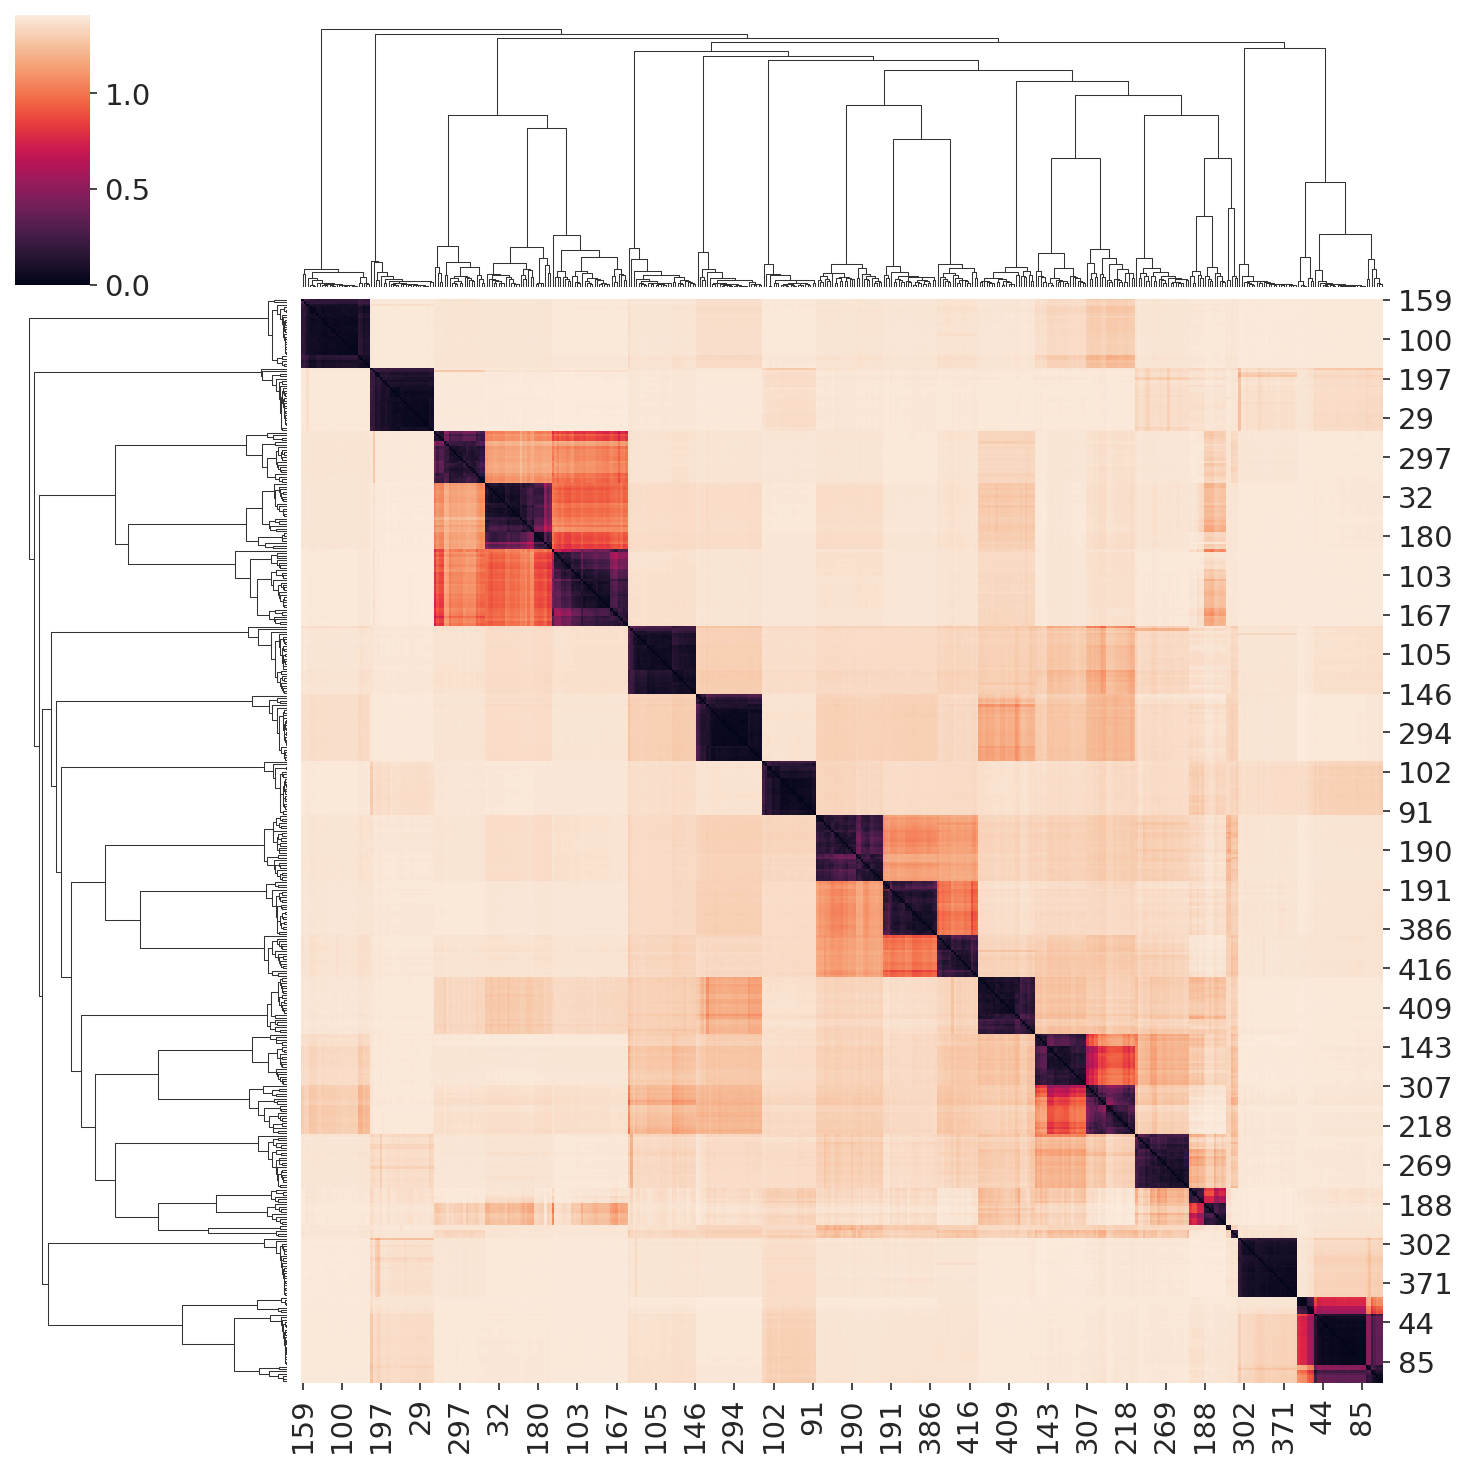

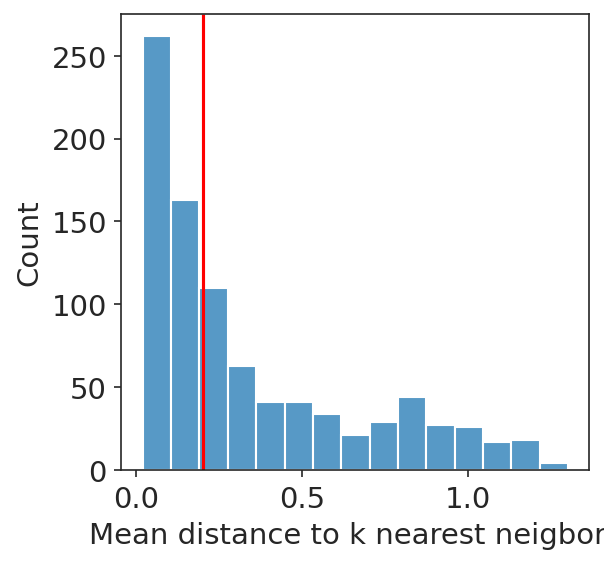

In [11]:
k_range = pipeline[-1].k_range

for k in k_range:
    print('k='+str(k))
    
    sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75, vector_friendly=True)
    sns.set_style("ticks")
    sns.clustermap(consensus_stat[k]['topk_euc_dist'].cpu().numpy())
    plt.show()
    
    sns.histplot(consensus_stat[k]['local_neigh_dist'].cpu().numpy())
    ymax = plt.gca().get_ylim()[1]
    plt.vlines(density_threshold, ymin=0, ymax=ymax, color='Red')
    plt.xlabel('Mean distance to k nearest neigbors')
    plt.ylim(0, ymax)
    
    plt.show()

In [11]:
# calculate reconstruction error
rec_errors = calculate_rec_error(dataset, pipeline)

100%|██████████| 325/325 [11:15<00:00,  2.08s/it]


In [12]:
silhouette_scores = {}
for k in k_range:
    silhouette_scores[k] = consensus_stat[k]['stability']
eval_metrics = pd.DataFrame.from_dict(silhouette_scores, orient='index')
eval_metrics.columns = ['stability']
eval_metrics['rec_error'] = rec_errors

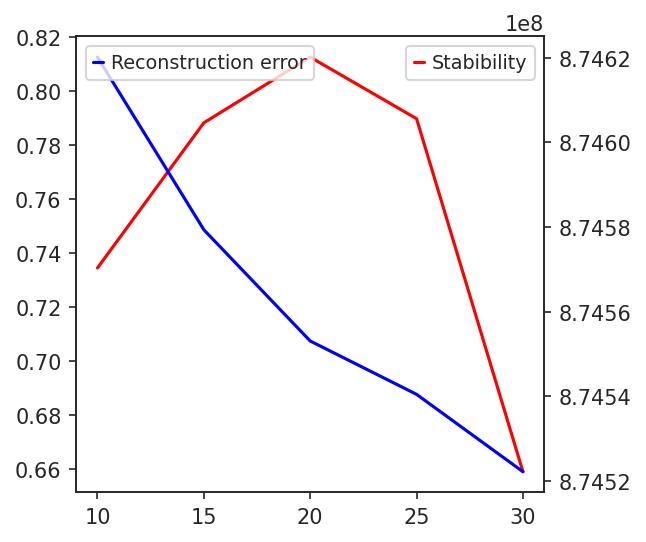

In [13]:
sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75, vector_friendly=True, fontsize=10)
sns.set_style("ticks")
plt.plot(eval_metrics.index, eval_metrics['stability'], 
         color='Red', label='Stabibility')
plt.legend(loc="upper right")
plt.twinx()
plt.plot(eval_metrics.index, eval_metrics['rec_error'], 
         color='Blue', label='Reconstruction error')
plt.legend(loc="upper left")

In [12]:
# get cell loading with best K
adata = get_embeddding(dataset, pipeline, the_best_k=20)

100%|██████████| 325/325 [06:25<00:00,  1.19s/it]


In [15]:
X 1000 X 30000
cell_loading 1000 X 20
full_D_20_kg 20 X 30000

torch.Size([20, 2000])

In [15]:
# visualization with UMAP
reducer = cuml.UMAP(
    n_neighbors=15,
    n_components=2,
    n_epochs=500,
    min_dist=0.15,
    metric='cosine'
)
embedding = reducer.fit_transform(adata.obsm['X_nmf'])
adata.obsm['X_nmf_umap'] = embedding

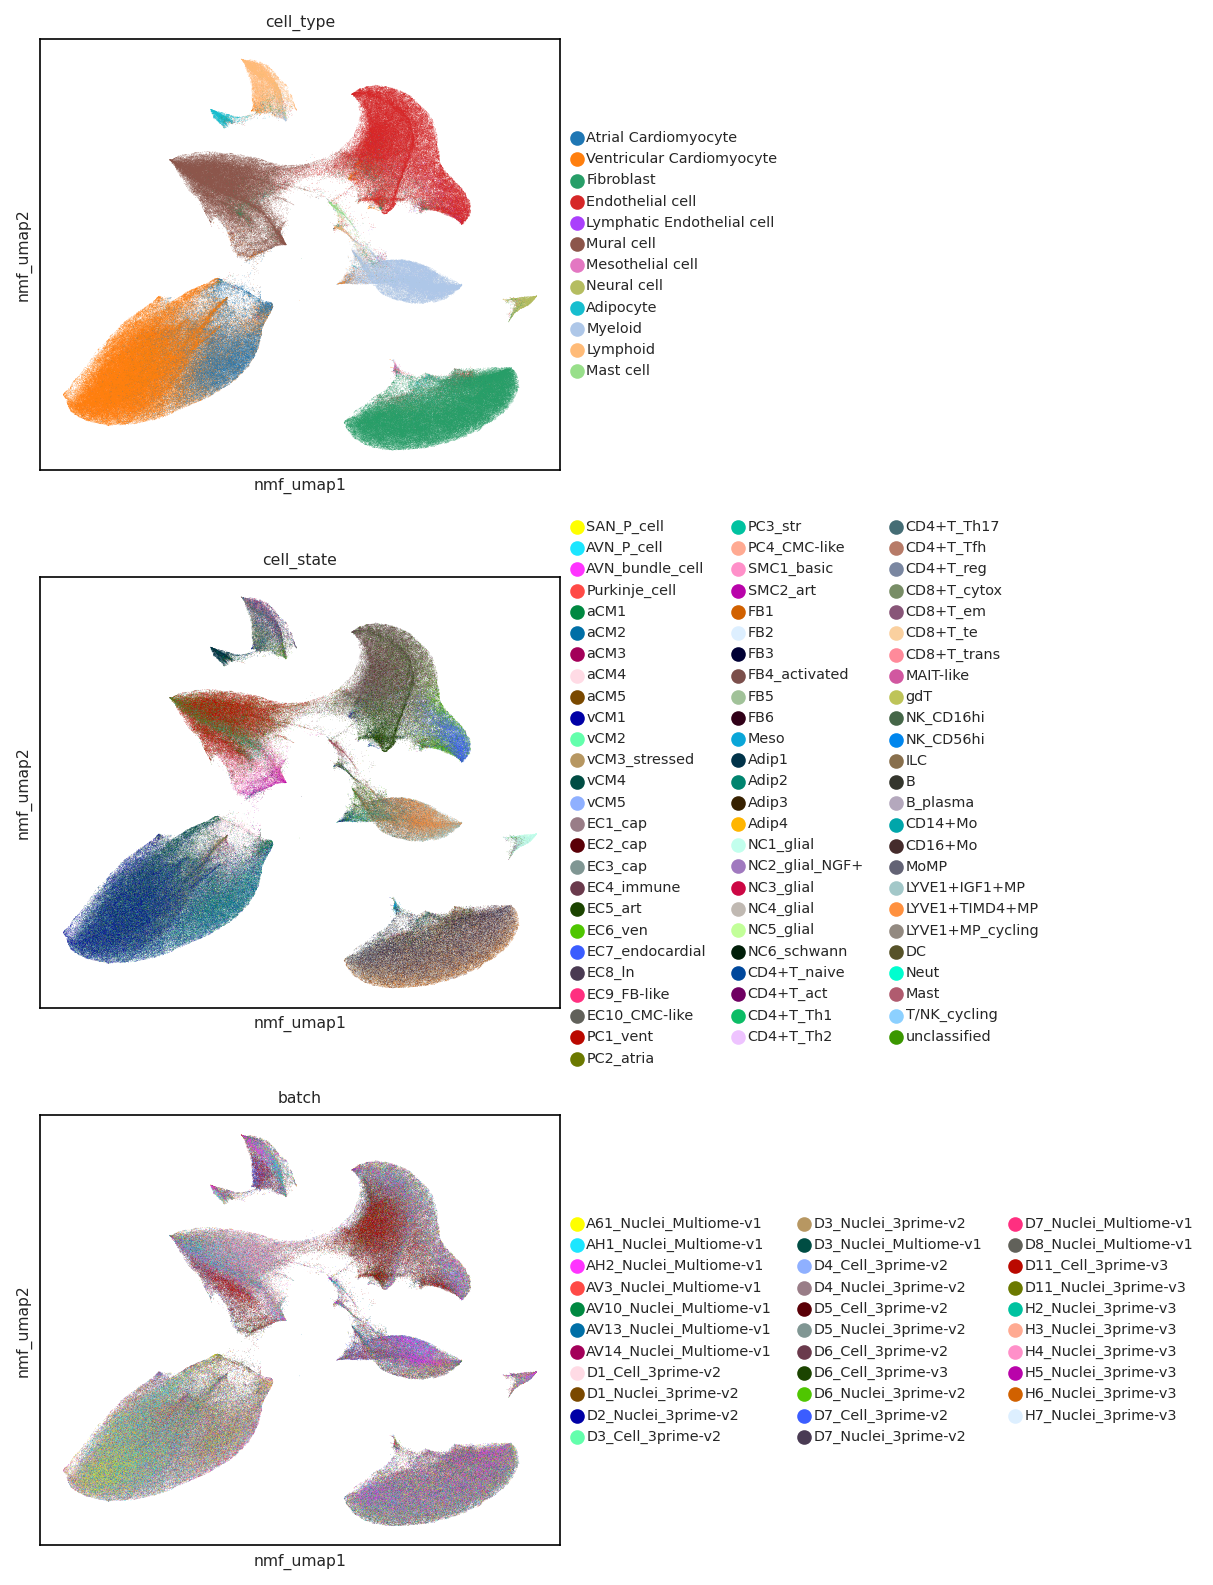

In [16]:
sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75, vector_friendly=True, fontsize=7.5)
sc.pl.embedding(adata, basis='nmf_umap', color=['cell_type', 'cell_state', 'batch'], ncols=1)